<i><b>Public AI</b></i>

# Mini-Batch SGD

### _Objective_
* 딥러닝에서 경사하강법 중 가장 많이 쓰이는 Mini-Batch SGD에 대해 배워보도록 하겠습니다. <br>
* Mini-Batch로도 학습이 어떻게 가능한지를 알아보도록 하겠습니다. <br>

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_seed(30)

## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 관계에 대한 데이터 셋입니다. <br>
아래와 같이 랜덤으로 2000개의 데이터셋을 만들었습니다.

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 2000) # 5% ~ 90% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.normal(0,0.01) 
           for x in invests]) # 예상 수익률

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 1400
test 데이터셋 크기 : 600


### 데이터 시각화

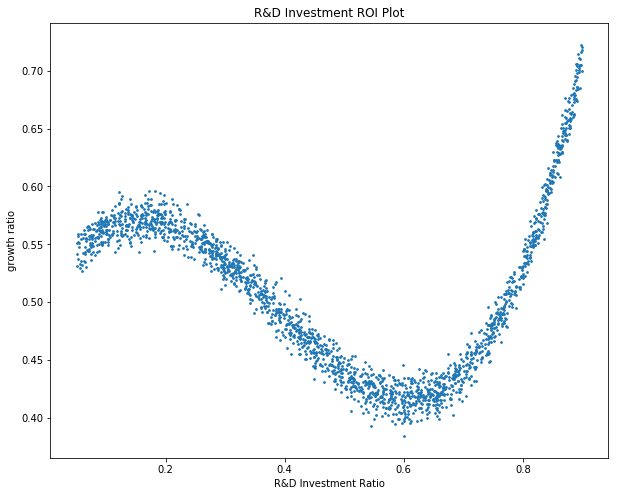

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

<br><br>

# \[ 1. 3층 신경망 모델 구성하기 \]

----

3층짜리 신경망을 구성해보도록 하겠습니다. 구성한 신경망을 통해 배치 사이즈에 따라 Learning Curve가 어떤 식으로 바뀌는지 확인해 보도록 하겠습니다.

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import he_normal, glorot_normal

from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD

In [5]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal())(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal())(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal())(hidden2)
    
model = Model(x, y_pred)
    
model.compile(SGD(1e-2),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

<br><br>

# \[ 2. 배치 사이즈에 따른 학습 곡선 비교 \]

----

Batch GD VS SGD VS Mini-Batch SGD로 나누어, 어떤 식의 차이가 있는지 관찰해보도록 하겠습니다.

<br>
## 1. Batch GD

* Batch GD는 Deterministic GD라고도 불립니다.<br>
* 매 학습 때마다 동일한 데이터를 가지고 경사하강법을 통해 학습하기 때문입니다.<br>
* 안정적으로 학습되나, 느리다는 단점이 존재합니다. <br>

In [6]:
full_size = len(train_invests)

start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    batch_size=full_size,
                    epochs=28000,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

학습 총 소요 시간 ---- 103.122s


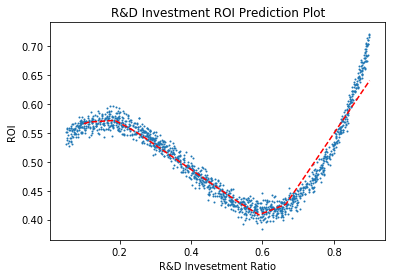

In [7]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

<br>
## 2. SGD(stochastic Gradient Descent)

* SGD는 확률적 경사 하강법으로, 데이터셋 중 하나씩 추출하여 학습시키는 방법을 의미합니다. <br>
* 매 학습 때마다 다른 데이터를 가지고 경사하강법을 통해 학습하기 때문에, Loss값이 진동하면서 떨어집니다..<br>
* 불안정적으로 학습되지만, 빠르게 계산할 수 있다는 장점이 존재합니다. <br>

In [8]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal())(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal())(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal())(hidden2)
    
model = Model(x, y_pred)
    
model.compile(SGD(1e-2),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

In [9]:
full_size = len(train_invests)

start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    batch_size=1,
                    epochs=28000//full_size,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

학습 총 소요 시간 ---- 25.119s


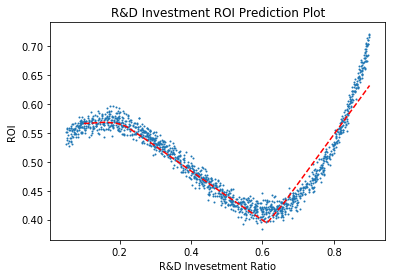

In [10]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

<br>
## 3. Mini-Batch SGD(stochastic Gradient Descent)

* Mini-Batch SGD는 Batch GD와 SGD의 장점을 섞은 방법으로, 1개의 데이터 대신 여러개의 데이터를 추출해 Gradient Descent을 적용하는 방법입니다. <br>
* 일반적으로 가장 많이 쓰는 방식입니다. <br>

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

x = Input((1,), name='x')
hidden1 = Dense(num_hidden1, 'relu', kernel_initializer=he_normal())(x)
hidden2 = Dense(num_hidden2, 'relu', kernel_initializer=he_normal())(hidden1)
y_pred = Dense(1, kernel_initializer=glorot_normal())(hidden2)
    
model = Model(x, y_pred)
    
model.compile(SGD(1e-2),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

In [13]:
full_size = len(train_invests)
batch_size = 10

start_time = time.time()
history = model.fit(train_invests,
                    train_growths,
                    batch_size=batch_size,
                    epochs=28000*batch_size//full_size,
                    verbose=0)

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

학습 총 소요 시간 ---- 24.329s


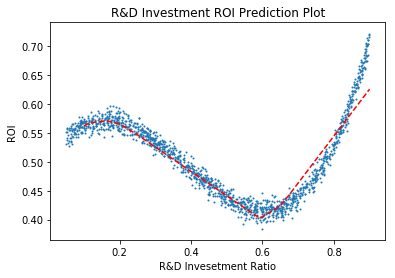

In [14]:
# 0부터 1까지 순서대로 1000개를 출력
test_xs = np.linspace(0.1,0.9,1000)
test_xs = test_xs.reshape(-1,1)
pred_ys = model.predict(test_xs)

plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r--')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---